In [3]:
#pip install scipy pandas numpy statistics geojson plotly

In [238]:
from sqlalchemy import create_engine, text, inspect, Table
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import numpy as np

In [7]:
engine = create_engine("postgresql://student:infomdss@db_dashboard:5432/dashboard")

In [249]:
query_6 = '''SELECT * FROM electricity_consumption'''
con = engine.connect()
dfpred = pd.read_sql(query_6, con, index_col = "index" )

In [250]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [251]:
dfpred.drop("Unnamed: 0", axis = 1, inplace = True)
dfpred['DATE'] = pd.to_datetime(dfpred[['year', 'month']].assign(day=1))
dfpred.drop("year", axis = 1, inplace= True)
dfpred.drop("month", axis = 1, inplace = True)
dcountry = "AUT"
dindicator = "Consumption"
dfpred = dfpred[(dfpred["country"] == dcountry) & (dfpred["indicator"] == dindicator)]
#dfpred["DATE"] = dfpred["DATE"].astype(str)
dfpred2 = dfpred[["DATE","gwh"]]
#dfpred2.dtypes
dfpred2.to_csv("elec_date.csv", index = False)

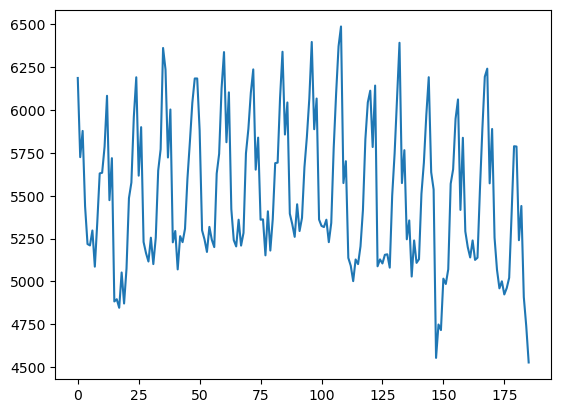

In [252]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

>expected=5000.6, predicted=5107.2
>expected=4923.9, predicted=4961.4
>expected=4961.2, predicted=5043.3
>expected=5021.2, predicted=5514.7
>expected=5395.3, predicted=5426.9
>expected=5788.7, predicted=5687.5
>expected=5787.0, predicted=6075.7
>expected=5240.4, predicted=6063.4
>expected=5440.1, predicted=5616.9
>expected=4908.5, predicted=5791.8
>expected=4739.4, predicted=5195.2
>expected=4526.9, predicted=4853.7
MAE: 317.239


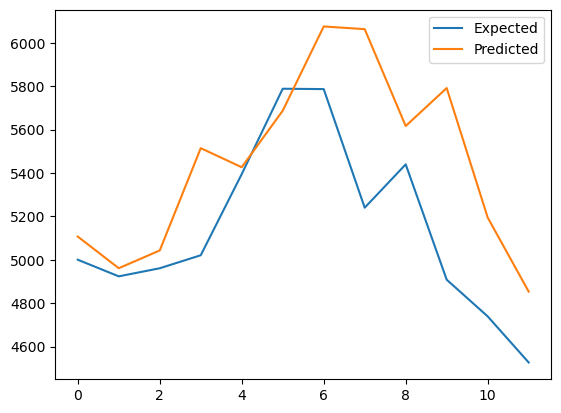

In [253]:
# forecast monthly births with random forest
## DIT MOet ER NIET IN DIT IS ALLEEN OM DE PARAMETERS TE OPTIMALISEREN GA IK NOG DOEN
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [260]:
# DIT IS DE UITEINDELIJKE PREDICTOR NOg niet geoptimaliseerd nu
# als je de maanden wil aanpassen doe je n_out in de onderste naar meer maanden en
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
#series = dfpred2["gwh"]
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6, n_out=36)  # Update n_out to 5
# split into input and output columns
trainX, trainy = train[:, :-36], train[:, -36:]  # Separate the last 5 columns as output
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-6:].flatten()

# make a 5-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))


Input: [5787.018 5240.429 5440.089 4908.547 4739.386 4526.915], Predicted: [[5174.918955 5519.342642 5676.717807 5977.836888 6189.37082  5694.636418
  5788.592292 4982.223513 5031.76795  4967.434648 5161.347959 5077.639784
  5160.893843 5572.552271 5705.259589 6067.827403 6192.38521  5627.685902
  5899.080055 5266.111901 5243.239279 5117.967665 5251.432194 5154.761499
  5210.255549 5578.022121 5831.548496 6128.972965 6226.244153 5745.672743
  5842.144273 5202.24896  5127.798807 5019.904782 5141.233168 5070.296731]]


In [262]:
resultsplot = pd.DataFrame(series)
resultsplot = resultsplot.reset_index()
resultsplot["DATE"] = pd.to_datetime(resultsplot["DATE"])
resultsplot["predict"] = False

In [263]:
result = yhat.reshape(-1)
for value in result:
    last_date = resultsplot["DATE"].max()
    new_date = last_date + pd.DateOffset(months=1)
    list_row = [new_date, value, True]
    resultsplot.loc[len(resultsplot)] = list_row
resultsplot.tail(7)
    

,DATE,gwh,predict
215,2025-12-01,5745.672743,True
216,2026-01-01,5842.144273,True
217,2026-02-01,5202.248960,True
218,2026-03-01,5127.798807,True
219,2026-04-01,5019.904782,True
220,2026-05-01,5141.233168,True
221,2026-06-01,5070.296731,True


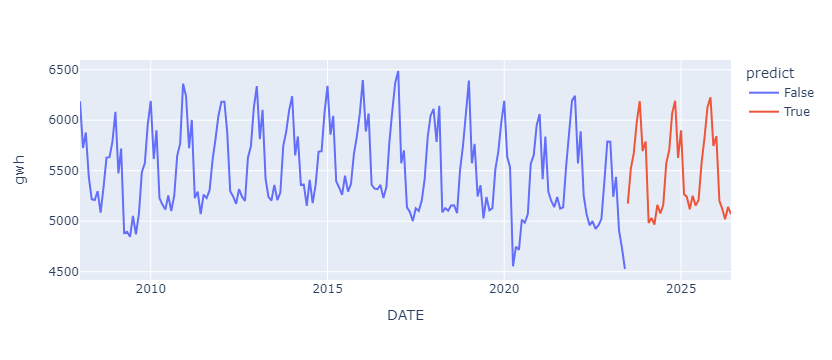

In [264]:
fig = px.line(resultsplot, x = "DATE",y ="gwh", color = "predict" )
fig.show()